# 1337 D00M

### description

In [1]:
import tensorflow as tf      # Deep Learning library
import numpy as np           # Handle matrices
from vizdoom import *        # Doom Environment

import random                # Handling random number generation
import time                  # Handling time calculation
from skimage import transform# Help us to preprocess the frames

from collections import deque# Ordered collection with ends
import matplotlib.pyplot as plt # Display graphs

import warnings # This ignore all the warning messages that are normally printed during the training because of skiimage
warnings.filterwarnings('ignore')
tf.enable_eager_execution()
import tensorflow.contrib.eager as tfe

### Create our a MDP environment

In [237]:
def create_environment():
    game = DoomGame()
    
    # Load the correct configuration
    game.load_config("take_cover.cfg")
    
    # Load the correct scenario (in our case basic scenario)
    game.set_doom_scenario_path("take_cover.wad")
    
    game.init()
    game.set_ticrate(200)
    
    # Here our possible actions
    left = [1, 0]
    right = [0, 1]
    possible_actions = [left, right]
    
    return game, possible_actions

In [238]:
game, possible_actions = create_environment()

### Encode temporal relationship

In [239]:
def preprocess_frame(frame):
    #print(frame.shape)
    # Greyscale frame already done in our vizdoom config
    # x = np.mean(frame,-1)
    
    # Crop the screen (remove the roof because it contains no information)
    cropped_frame = frame[30:-10,30:-30]
    
    # Normalize Pixel Values
    normalized_frame = cropped_frame/255.0
    
    # Resize
    preprocessed_frame = transform.resize(normalized_frame, [84,84])
    
    return preprocessed_frame

In [240]:
stack_size = 4 # We stack 4 frames

# Initialize deque with zero-images one array for each image
stacked_frames  =  deque([np.zeros((84,84), dtype=np.int) for i in range(stack_size)], maxlen=4) 

def stack_frames(stacked_frames, state, is_new_episode):
    # Preprocess frame
    frame = preprocess_frame(state)
    
    if is_new_episode:
        # Clear our stacked_frames
        stacked_frames = deque([np.zeros((84,84), dtype=np.int) for i in range(stack_size)], maxlen=4)
        
        # Because we're in a new episode, copy the same frame 4x
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        
        # Stack the frames
        stacked_state = np.stack(stacked_frames, axis=2)
        
    else:
        # Append frame to deque, automatically removes the oldest frame
        stacked_frames.append(frame)

        # Build the stacked state (first dimension specifies different frames)
        stacked_state = np.stack(stacked_frames, axis=2) 
    
    return stacked_state, stacked_frames

### Define hyperparameters

In [241]:
### MODEL HYPERPARAMETERS
state_size = [84,84,4]      # Our input is a stack of 4 frames hence 84x84x4 (Width, height, channels) 
action_size = game.get_available_buttons_size()              # 3 possible actions: left, right, shoot
learning_rate =  0.0002      # Alpha (aka learning rate)

### TRAINING HYPERPARAMETERS
total_episodes = 500        # Total episodes for training
max_steps = 1000              # Max possible steps in an episode
batch_size = 64             

# Exploration parameters for epsilon greedy strategy
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Q learning hyperparameters
gamma = 0.95               # Discounting rate

### MEMORY HYPERPARAMETERS
pretrain_length = batch_size   # Number of experiences stored in the Memory when initialized for the first time
memory_size = 1000000          # Number of experiences the Memory can keep

### MODIFY THIS TO FALSE IF YOU JUST WANT TO SEE THE TRAINED AGENT
training = True

## TURN THIS TO TRUE IF YOU WANT TO RENDER THE ENVIRONMENT
episode_render = False

### Add an experience replay mechanism to make more efficient use of observed experience

In [242]:
class Memory():
    def __init__(self, max_size):
        self.buffer = deque(maxlen = max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        buffer_size = len(self.buffer)
        index = np.random.choice(np.arange(buffer_size),
                                size = batch_size,
                                replace = False)
        
        return [self.buffer[i] for i in index]

In [244]:
# Instantiate memory
memory = Memory(max_size = memory_size)

# Render the environment
game.new_episode()

for i in range(pretrain_length):
    # If it's the first step
    if i == 0:
        # Get the first frame
        state = game.get_state().screen_buffer
        state, stacked_frames = stack_frames(stacked_frames, state, True)
    
    action = random.choice(possible_actions)  # Random action
    reward = game.make_action(action)         # Get the rewards
    done = game.is_episode_finished()         # Look if the episode is finished
    
    # If we're dead
    if done:
        next_state = np.zeros(state.shape)                     # The episode is over
        memory.add((state, action, reward, next_state, done))  # Add experience to memory
        game.new_episode()                                     # Start a new episode
        state = game.get_state().screen_buffer                 # Get the first frame
        state, stacked_frames = stack_frames(stacked_frames, state, True) # Stack the frames
        
    else:
        next_state = game.get_state().screen_buffer            # Get the next state
        next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
        memory.add((state, action, reward, next_state, done))  # Add experience to memory
        state = next_state                                     # Update current state

### Define a block of CNN's for Q-value estimation

In [245]:
class ConvBnEluBlock(tf.keras.Model):
    def __init__(self, filters, kernel, strides, padding):
        super(ConvBnEluBlock, self).__init__()
        self.cnn = tf.keras.layers.Conv2D(filters, (kernel, kernel), strides=(strides, strides), padding=padding, kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        self.bn = tf.keras.layers.BatchNormalization(trainable=True, epsilon=1e-5)

    def call(self, inputs, training=None, mask=None):
        x = self.cnn(inputs)
        x = self.bn(x)
        x = tf.nn.elu(x)
        return x

In [246]:
class DQNetwork(tf.keras.Model):
    def __init__(self, num_actions):
        super(DQNetwork, self).__init__()
        self.block1 = ConvBnEluBlock(32, kernel=8, strides=4, padding='valid') 
        self.block2 = ConvBnEluBlock(64, kernel=4, strides=2, padding='valid')
        self.block3 = ConvBnEluBlock(128, kernel=4, strides=2, padding='valid')
        self.flatten = tf.layers.Flatten()
        self.fc = tf.keras.layers.Dense(units=512, activation=tf.nn.elu, kernel_initializer=tf.contrib.layers.xavier_initializer())
        self.out = tf.keras.layers.Dense(units=num_actions, activation=None, kernel_initializer=tf.contrib.layers.xavier_initializer())

    def call(self, inputs, training=None, mask=None, plot=False):
        x = self.block1(inputs) # [84, 84, 4] -> [20, 20, 32]
        if plot:
            return x
        x = self.block2(x) # [20, 20, 32] ->  [9, 9, 64]
        x = self.block3(x) #  [9, 9, 64] -> [3, 3, 128]
        x = self.flatten(x) # [9, 9, 64] -> [1152]
        x = self.fc(x) # [1152] -> [512]
        output = self.out(x) # [512] -> [2]

        return output 

With $ϵ$ select a random action $a_t$, otherwise select $a_t=argmax_{a}Q(s',a')$

In [247]:
def predict_action(explore_start, explore_stop, decay_rate, decay_step, state, actions, model):
    ## EPSILON GREEDY STRATEGY
    # Choose action a from state s using epsilon greedy.
    ## First we randomize a number
    exp_exp_tradeoff = np.random.rand()

    # Here we'll use an improved version of our epsilon greedy strategy used in Q-learning notebook
    explore_probability = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * decay_step)
    
    if (explore_probability > exp_exp_tradeoff):
        # Make a random action (exploration)
        action = random.choice(possible_actions)
        
    else:
        # Get action from Q-network (exploitation)
        # Estimate the Qs values state
        Qs = model(tf.cast(np.expand_dims(state, 0), tf.float32))
        # Take the biggest Q value (= the best action)
        choice = np.argmax(Qs)
        action = possible_actions[int(choice)]
                
    return action, explore_probability

In [248]:
global_step = tf.train.get_or_create_global_step()

logdir = "/home/arialinvlad/Deep_reinforcement_learning_Course/DQL/Doom/take_cover/tb/"
writer = tf.contrib.summary.create_file_writer(logdir)
writer.set_as_default()

# for i in range(10):
#     # Must include a record_summaries method
#     with tf.contrib.summary.record_summaries_every_n_global_steps(3):
#         global_step.assign_add(1)
#         # your model code goes here
#         print(global_step)
#         opertaion = tf.contrib.summary.scalar('loss', i)
#         print(opertaion)    

In [249]:
model = DQNetwork(num_actions=2)
saver = 0

game, possible_actions = create_environment()

In [250]:
optimizer = tf.train.RMSPropOptimizer(learning_rate)
global_step = tf.train.get_or_create_global_step()

with tf.contrib.summary.always_record_summaries():

    if training == True:
        # Initialize the decay rate (that will use to reduce epsilon) 
        decay_step = 0

        # Init the game
        game.init()

        for episode in range(total_episodes):
            # Set step to 0
            step = 0

            # Initialize the rewards of the episode
            episode_rewards = []

            # Make a new episode and observe the first state
            game.new_episode()
            state = game.get_state().screen_buffer

            # Remember that stack frame function also call our preprocess function.
            state, stacked_frames = stack_frames(stacked_frames, state, True)

            while step < max_steps:
                step += 1

                # Increase decay_step
                decay_step +=1

                # Predict the action to take and take it
                action, explore_probability = predict_action(explore_start, explore_stop, decay_rate, decay_step, state, possible_actions, model)

                # Do the action
                reward = game.make_action(action)

                # Look if the episode is finished
                done = game.is_episode_finished()

                # Add the reward to total reward
                episode_rewards.append(reward)

                # If the game is finished
                if done:
                    # the episode ends so no next state
                    next_state = np.zeros((84,84), dtype=np.int)
                    next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)

                    # Set step = max_steps to end the episode
                    step = max_steps

                    # Get the total reward of the episode
                    total_reward = np.sum(episode_rewards)

                    print('Episode: {}'.format(episode),
                              'Total reward: {}'.format(total_reward),
                              'Training loss: {:.4f}'.format(loss),
                              'Explore P: {:.4f}'.format(explore_probability))

                    memory.add((state, action, reward, next_state, done))

                else:
                    # Get the next state
                    next_state = game.get_state().screen_buffer

                    # Stack the frame of the next_state
                    next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)

                    # Add experience to memory
                    memory.add((state, action, reward, next_state, done))

                    # st+1 is now our current state
                    state = next_state

                batch = memory.sample(batch_size)
                states_mb = np.array([each[0] for each in batch], ndmin=3)
                actions_mb = np.array([each[1] for each in batch])
                rewards_mb = np.array([each[2] for each in batch]) 
                next_states_mb = np.array([each[3] for each in batch], ndmin=3)
                dones_mb = np.array([each[4] for each in batch])

                target_Qs_batch = []

                with tf.GradientTape() as tape:
                    Qs_next_state = model(tf.cast(next_states_mb, tf.float32), training=True)
                    if not saver:
                        saver = tfe.Saver(model.variables)


                    # Set Q_target = r if the episode ends at s+1, otherwise set Q_target = r + gamma*maxQ(s', a')
                    for i in range(0, len(batch)):
                        terminal = dones_mb[i]

                        # If we are in a terminal state, only equals reward
                        if terminal:
                            target_Qs_batch.append(rewards_mb[i])

                        else:
                            target = rewards_mb[i] + gamma * np.max(Qs_next_state[i])
                            target_Qs_batch.append(target)


                    targets_mb = np.array([each for each in target_Qs_batch])
                    Q = tf.reduce_sum(tf.multiply(Qs_next_state, actions_mb), axis=1)
                    loss = tf.reduce_mean(tf.square(targets_mb - Q))
                grads = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(grads, model.trainable_variables))
#                 operation = tf.contrib.summary.scalar('loss', loss)
#                 print(operation)

            if episode % 5 == 0 and episode:
                saver.save("./models/model.ckpt", global_step=global_step)
                print("Model Saved")    

Episode: 0 Total reward: 107.0 Training loss: 1.0791 Explore P: 0.9895
Episode: 1 Total reward: 50.0 Training loss: 2.6236 Explore P: 0.9846
Episode: 2 Total reward: 83.0 Training loss: 0.6040 Explore P: 0.9765
Episode: 3 Total reward: 94.0 Training loss: 0.5058 Explore P: 0.9675
Episode: 4 Total reward: 48.0 Training loss: 0.5009 Explore P: 0.9629
Episode: 5 Total reward: 73.0 Training loss: 0.5474 Explore P: 0.9560
Model Saved
Episode: 6 Total reward: 48.0 Training loss: 0.3184 Explore P: 0.9514
Episode: 7 Total reward: 53.0 Training loss: 0.5707 Explore P: 0.9465
Episode: 8 Total reward: 53.0 Training loss: 0.0145 Explore P: 0.9415
Episode: 9 Total reward: 83.0 Training loss: 0.1880 Explore P: 0.9338
Episode: 10 Total reward: 49.0 Training loss: 0.0495 Explore P: 0.9293
Model Saved
Episode: 11 Total reward: 47.0 Training loss: 0.0424 Explore P: 0.9250
Episode: 12 Total reward: 114.0 Training loss: 0.0158 Explore P: 0.9146
Episode: 13 Total reward: 137.0 Training loss: 0.1796 Explore

KeyboardInterrupt: 

In [218]:
game, possible_actions = create_environment()

totalScore = 0

# Load the model
saver.restore("./models/model.ckpt-0")
game.init()
for i in range(1):

    done = False

    game.new_episode()

    state = game.get_state().screen_buffer
    state, stacked_frames = stack_frames(stacked_frames, state, True)

    while not game.is_episode_finished():
        # Take the biggest Q value (= the best action)
        Qs = model(tf.cast(np.expand_dims(state, 0), tf.float32))

        # Take the biggest Q value (= the best action)
        choice = np.argmax(Qs)
        action = possible_actions[int(choice)]

        game.make_action(action)
        done = game.is_episode_finished()
        score = game.get_total_reward()

        if done:
            break  

        else:
            next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
            state = next_state

    score = game.get_total_reward()
    print("Score: ", score)
game.close()

AttributeError: 'int' object has no attribute 'restore'

### Network Visualization 

In [220]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.

    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.array(tf.reduce_min(weights))
    w_max = np.array(tf.reduce_max(weights))

    # Number of filters used in the conv. layer.
    num_filters = weights.shape[3].value

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = weights[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

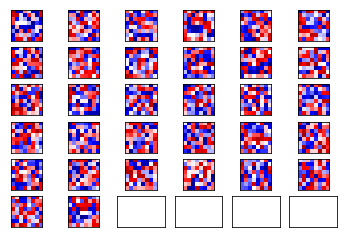

In [222]:
plot_conv_weights(model.block1.weights[0])

In [223]:
def plot_image(image):
    plt.imshow(image.reshape((84, 84)),
               interpolation='nearest',
               cmap='binary')

    plt.show()

In [224]:
def plot_conv_layer(layer, image):
    # Assume layer is a TensorFlow op that outputs a 4-dim tensor
    # which is the output of a convolutional layer,
    # e.g. layer_conv1 or layer_conv2.

    # Number of filters used in the conv. layer.
    num_filters = layer.shape[3].value

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = layer[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [225]:
batch = memory.sample(batch_size)
next_states_mb = np.array([each[3] for each in batch], ndmin=3)
inputs = model(tf.cast(next_states_mb, tf.float32), training=False, plot=True)

## Test environment 

In [235]:
def test_environment():
    game = DoomGame()
    game.load_config("take_cover.cfg")
    game.set_doom_scenario_path("take_cover.wad")
    game.init()
    left = [1, 0]
    right = [0, 1]
    actions = [left, right]

    episodes = 100
    for i in range(episodes):
        game.new_episode()
        while not game.is_episode_finished():
            state = game.get_state()
            img = state.screen_buffer
            frame = preprocess_frame(img)
            misc = state.game_variables
            action = random.choice(actions)
            reward = game.make_action(action)
#         plot_conv_layer(inputs, frame)
#         plot_image(frame)
        print ("Result:", game.get_total_reward())
#         time.sleep(2)
    game.close()
game, possible_actions = create_environment()
test_environment()

Result: 140.0
Result: 90.0
Result: 61.0
Result: 56.0
Result: 54.0
Result: 149.0
Result: 87.0
Result: 57.0
Result: 56.0
Result: 168.0
Result: 50.0
Result: 115.0
Result: 55.0
Result: 74.0
Result: 57.0
Result: 69.0
Result: 47.0
Result: 58.0
Result: 51.0
Result: 70.0
Result: 83.0
Result: 54.0
Result: 58.0
Result: 93.0
Result: 51.0
Result: 148.0
Result: 47.0
Result: 93.0
Result: 54.0
Result: 64.0
Result: 66.0
Result: 54.0
Result: 56.0
Result: 56.0
Result: 51.0
Result: 54.0
Result: 56.0
Result: 62.0
Result: 48.0
Result: 51.0
Result: 53.0
Result: 83.0
Result: 110.0
Result: 83.0
Result: 102.0
Result: 51.0
Result: 52.0
Result: 84.0
Result: 57.0
Result: 95.0
Result: 50.0
Result: 98.0
Result: 52.0
Result: 62.0
Result: 62.0
Result: 71.0
Result: 57.0
Result: 96.0
Result: 53.0
Result: 145.0
Result: 47.0
Result: 58.0
Result: 59.0
Result: 152.0
Result: 55.0
Result: 84.0
Result: 57.0
Result: 53.0
Result: 72.0
Result: 52.0
Result: 50.0
Result: 52.0
Result: 70.0
Result: 53.0
Result: 50.0
Result: 49.0
Res